# **Overview:**

Chương trình này là tiếp nối của chương trình Part-2_Visualization.ipynb

Chương trình là thử nghiệm các mô hình Machine Learning trên tập dữ liệu đã được xử lý cũng như có cái nhìn tổng quan từ 2 phần trước.

# **6. Khai báo và cài đặt cần sử dụng**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from datetime import datetime
import warnings

In [2]:
from pylab import rcParams

rcParams['figure.figsize'] = 16,9

### **Đọc dữ liệu**

In [3]:
# from google.colab import drive
# drive.mount('data')

In [81]:
df = pd.read_csv('data/new-processed2.csv')

In [82]:
df

,Index,Domain,Have_IP,Have_At,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix_Suffix,DNS_Record,Web_Traffic,Domain_Age,Domain_End,iFrame,Mouse_Over,Right_Click,Web_Forwards,Label
0,0,56secureusersbusinessbt.weebly.com,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,1,pintakasi.live,0,0,0,4,0,0,0,0,0,1,1,1,1,1,1,1,1
2,2,pintakasi.live,0,0,0,4,0,0,0,0,0,1,1,1,1,1,1,1,1
3,3,areaclienticred-info.preview-domain.com,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,4,credemsecurity-info.preview-domain.com,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12875,12875,hotnewhiphop.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12876,12876,github.githubassets.com,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
12877,12877,dailybreeze.com,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
12878,12878,freshdesk.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Kiểm tra độ quan trọng của đăc trưng (feature important)**

In [83]:
df.columns

Index(['Index', 'Domain', 'Have_IP', 'Have_At', 'URL_Length', 'URL_Depth',
       'Redirection', 'https_Domain', 'TinyURL', 'Prefix_Suffix', 'DNS_Record',
       'Web_Traffic', 'Domain_Age', 'Domain_End', 'iFrame', 'Mouse_Over',
       'Right_Click', 'Web_Forwards', 'Label'],
      dtype='object')

In [84]:
features = ['Have_IP', 'Have_At', 'URL_Length', 'URL_Depth',
       'Redirection', 'https_Domain', 'TinyURL', 'Prefix_Suffix',
       'DNS_Record', 'Web_Traffic', 'Domain_Age', 'Domain_End',
       'Mouse_Over', 'Right_Click', 'Web_Forwards']

In [85]:
X = df[features]
y = df['Label']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [87]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [88]:
rf.feature_importances_

array([0.00082187, 0.00169686, 0.00324284, 0.41956724, 0.00460988,
       0.00044183, 0.01480362, 0.07419746, 0.01018297, 0.41552622,
       0.02086478, 0.01384455, 0.00688104, 0.00567786, 0.00764098])

<BarContainer object of 15 artists>

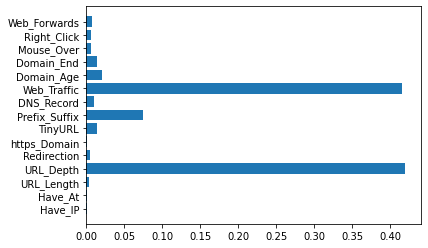

In [89]:
plt.barh(features, rf.feature_importances_)

# **7. Huấn luyện mô hình - Classification**

**Split dataset**

In [90]:
Y = y

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
X_train,X_test,Y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [93]:
print('Kích thước tập huấn luyện: ', X_train.shape, y_train.shape)
print('Kích thước tập kiểm tra: ', X_test.shape, y_test.shape)

Kích thước tập huấn luyện:  (10304, 15) (9016,)
Kích thước tập kiểm tra:  (2576, 15) (2576,)


In [94]:
# Hàm tính độ chính xác, ma trận nhầm lẫn, Recall, precision, f1 score và vẽ đồ thị ROC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
def evaluate_model(model, X_test, y_test, y_prediction):
  print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
  #Accuracy
  print("1. Accuracy:",metrics.accuracy_score(y_prediction,y_test))
  # confusion_matrix
  print('2. confusion_matrix:')
  print(confusion_matrix(y_prediction,y_test))
  # recall_score
  print('3. recall_score: ', recall_score(y_prediction,y_test))
  # precision_score
  print('4. precision_score: ', precision_score(y_prediction,y_test))
  # f1_score
  print('5. f1_score: ', f1_score(y_prediction,y_test))
  # ROC plot
  print('6. Biểu đồ ROC của mô hình:')
  metrics.plot_roc_curve(model, X_test, y_test)
  plt.show()

**Logistic Regression**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8559782608695652
2. confusion_matrix:
[[ 732   77]
 [ 294 1473]]
3. recall_score:  0.833616298811545
4. precision_score:  0.9503225806451613
5. f1_score:  0.8881519445281881
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


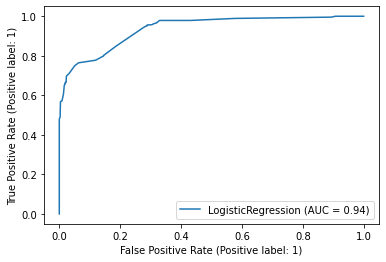

In [96]:
#Given smote, we have to do a little adjustment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(fit_intercept=True, penalty='l2')
logreg.fit(X_train, Y_train)

logregprediction=logreg.predict(X_test)

evaluate_model (logreg, X_test, y_test, logregprediction)

**Linear Discriminant Analysis**

In [97]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda = LinearDiscriminantAnalysis()
# lda.fit(X_train, Y_train)

# lda_prediction=lda.predict(X_test)

# evaluate_model (lda, X_test, y_test, lda_prediction)

**Gaussian Naive Bayes**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.6867236024844721
2. confusion_matrix:
[[1026  807]
 [   0  743]]
3. recall_score:  1.0
4. precision_score:  0.47935483870967743
5. f1_score:  0.6480593109463585
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


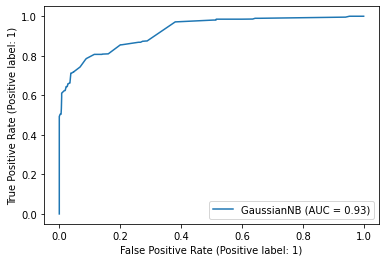

In [98]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)

gnbprediction=gnb.predict(X_test)

evaluate_model (gnb, X_test, y_test, gnbprediction)

**Decision Tree Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8707298136645962
2. confusion_matrix:
[[ 802  109]
 [ 224 1441]]
3. recall_score:  0.8654654654654654
4. precision_score:  0.9296774193548387
5. f1_score:  0.8964230171073095
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


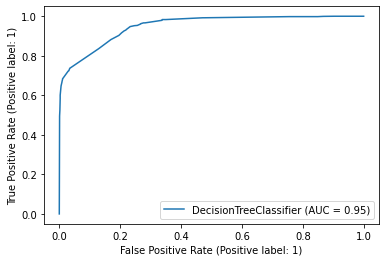

In [99]:
from sklearn.tree import DecisionTreeClassifier

dtc= DecisionTreeClassifier(random_state=42)
dtc.fit(X_train,Y_train)

dtcprediction=dtc.predict(X_test)

evaluate_model (dtc, X_test, y_test, dtcprediction)

**Random Forest Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8707298136645962
2. confusion_matrix:
[[ 802  109]
 [ 224 1441]]
3. recall_score:  0.8654654654654654
4. precision_score:  0.9296774193548387
5. f1_score:  0.8964230171073095
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


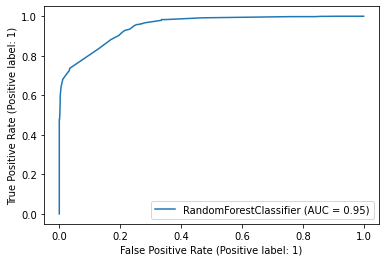

In [100]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_jobs=-1,random_state=123)
#learning
rfc.fit(X_train,Y_train)
#Prediction
rfcprediction=rfc.predict(X_test)

evaluate_model (rfc, X_test, y_test, rfcprediction)


**SVM Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8722826086956522
2. confusion_matrix:
[[ 773   76]
 [ 253 1474]]
3. recall_score:  0.8535031847133758
4. precision_score:  0.9509677419354838
5. f1_score:  0.899603295697284
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


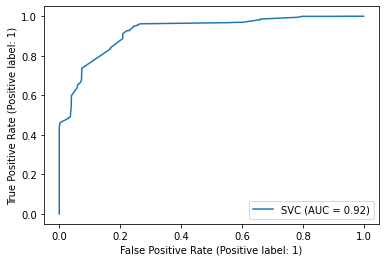

In [101]:
from sklearn import svm
#making the instance
svc = svm.SVC(random_state=123)
#learning
svc.fit(X_train,Y_train)
#Prediction
svcprediction=svc.predict(X_test)

evaluate_model (svc, X_test, y_test, svcprediction)

**K-NearestNeighbours Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8536490683229814
2. confusion_matrix:
[[ 731   82]
 [ 295 1468]]
3. recall_score:  0.8326715825297788
4. precision_score:  0.9470967741935484
5. f1_score:  0.8862058557198914
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


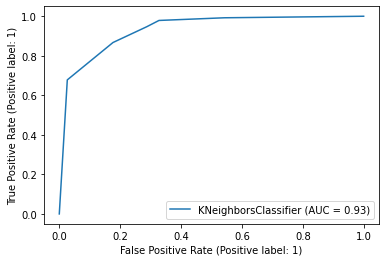

In [102]:
from sklearn.neighbors import KNeighborsClassifier
#making the instance
knn = KNeighborsClassifier()
#learning
knn.fit(X_train,Y_train)
#Prediction
knnprediction=knn.predict(X_test)

evaluate_model (knn, X_test, y_test, knnprediction)

**Ada Boost**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8555900621118012
2. confusion_matrix:
[[ 720   66]
 [ 306 1484]]
3. recall_score:  0.829050279329609
4. precision_score:  0.9574193548387097
5. f1_score:  0.8886227544910179
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


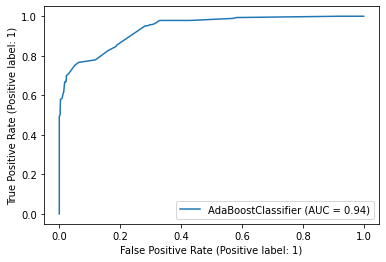

In [103]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=200, random_state=44)

#learning
ada_model.fit(X_train,Y_train)
#Prediction
ada_modelprediction=ada_model.predict(X_test)

evaluate_model (ada_model, X_test, y_test, ada_modelprediction)

**XGB Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8707298136645962
2. confusion_matrix:
[[ 802  109]
 [ 224 1441]]
3. recall_score:  0.8654654654654654
4. precision_score:  0.9296774193548387
5. f1_score:  0.8964230171073095
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


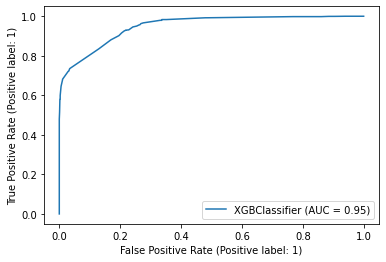

In [104]:
from xgboost import XGBClassifier

XGB_1 = XGBClassifier(objective='binary:logistic',scale_pos_weight=1,n_estimators=85, eta=0.3, subsample=1, colsample_bytree=1)

#learning
XGB_1.fit(X_train,Y_train)
#Prediction
XGB_modelprediction=XGB_1.predict(X_test)

evaluate_model (XGB_1, X_test, y_test, XGB_modelprediction)

**XGB Classifier Ver_2**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8707298136645962
2. confusion_matrix:
[[ 802  109]
 [ 224 1441]]
3. recall_score:  0.8654654654654654
4. precision_score:  0.9296774193548387
5. f1_score:  0.8964230171073095
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


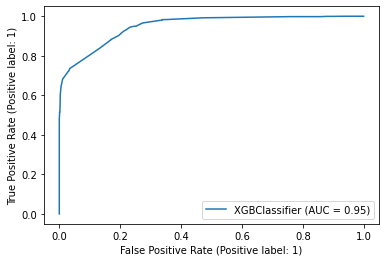

In [105]:
xgb_2 = XGBClassifier(learning_rate=0.4,max_depth=7)
#learning
xgb_2.fit(X_train,Y_train)
#Prediction
xgb_2_modelprediction_v2=xgb_2.predict(X_test)

evaluate_model (xgb_2, X_test, y_test, xgb_2_modelprediction_v2)

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8707298136645962
2. confusion_matrix:
[[ 802  109]
 [ 224 1441]]
3. recall_score:  0.8654654654654654
4. precision_score:  0.9296774193548387
5. f1_score:  0.8964230171073095
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


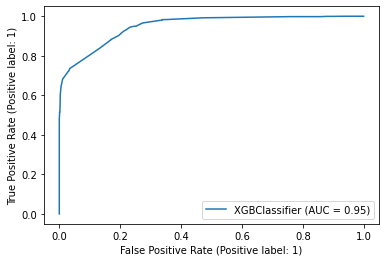

In [106]:
from xgboost import XGBClassifier

# instantiate the model
xgb_3 = XGBClassifier(learning_rate=0.4,max_depth=7)
#fit the model
xgb_3.fit(X_train, Y_train)

#predicting the target value from the model for the samples
y_test_xgb = xgb_3.predict(X_test)

evaluate_model (xgb_3, X_test, y_test, y_test_xgb)

**Light GBM**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.7383540372670807
2. confusion_matrix:
[[1024  672]
 [   2  878]]
3. recall_score:  0.9977272727272727
4. precision_score:  0.5664516129032258
5. f1_score:  0.7226337448559671
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


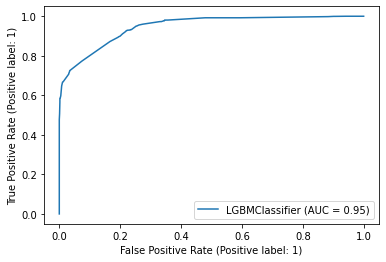

In [107]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, objective='binary',
                          class_weight={0:25, 1:1}, learning_rate=0.01,
                          boosting_type='dart')
lgbm_clf.fit(X_train, Y_train)

#Prediction
LGBM_modelprediction=lgbm_clf.predict(X_test)

evaluate_model (lgbm_clf, X_test, y_test, LGBM_modelprediction)

**Votting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.827639751552795
2. confusion_matrix:
[[ 991  409]
 [  35 1141]]
3. recall_score:  0.9702380952380952
4. precision_score:  0.7361290322580645
5. f1_score:  0.8371239911958915
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


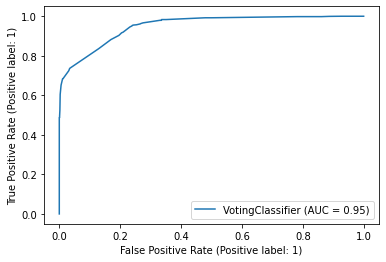

In [108]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

clf1 = RandomForestClassifier(n_estimators=200, class_weight={0: 100, 1: 1})
clf2 = GradientBoostingClassifier(n_estimators=1000, max_depth=7)
clf3 = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})
clf4 = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01)
pos_clf = VotingClassifier(estimators=[('pos', clf1), ('gb', clf2),
                                        ('et', clf3), ('xgb', clf4)],
                            voting='soft',
                            weights=[1, 2, 1, 1])

pos_clf.fit(X_train, Y_train)

#Prediction
Vot_modelprediction=pos_clf.predict(X_test)

evaluate_model (pos_clf, X_test, y_test, Vot_modelprediction)

**Gradient Boosting Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8707298136645962
2. confusion_matrix:
[[ 802  109]
 [ 224 1441]]
3. recall_score:  0.8654654654654654
4. precision_score:  0.9296774193548387
5. f1_score:  0.8964230171073095
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


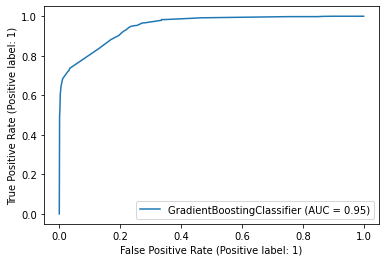

In [109]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

GBoost = GradientBoostingClassifier(n_estimators=1000, max_depth=7)


GBoost.fit(X_train, Y_train)

#Prediction
GBoost_modelprediction=GBoost.predict(X_test)

evaluate_model (GBoost, X_test, y_test, GBoost_modelprediction)

**Extra Trees Classifier**

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.7131211180124224
2. confusion_matrix:
[[1024  737]
 [   2  813]]
3. recall_score:  0.9975460122699387
4. precision_score:  0.5245161290322581
5. f1_score:  0.6875264270613108
6. Biểu đồ ROC của mô hình:


/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


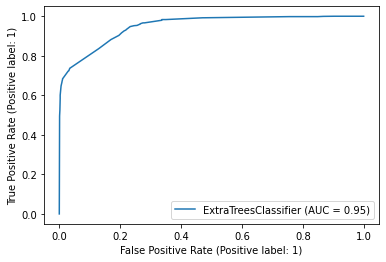

In [110]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier

Extra = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})


Extra.fit(X_train, Y_train)

#Prediction
Extra_modelprediction=Extra.predict(X_test)

evaluate_model (Extra, X_test, y_test, Extra_modelprediction)

**Cat Boosting**

In [111]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


0:	learn: 0.4607111	total: 12.9ms	remaining: 12.9s
1:	learn: 0.3633019	total: 22.2ms	remaining: 11.1s
2:	learn: 0.3221668	total: 27.9ms	remaining: 9.29s
3:	learn: 0.2963247	total: 36.6ms	remaining: 9.12s
4:	learn: 0.2783788	total: 46.1ms	remaining: 9.18s
5:	learn: 0.2689224	total: 51.8ms	remaining: 8.58s
6:	learn: 0.2633366	total: 59ms	remaining: 8.37s
7:	learn: 0.2588954	total: 68.6ms	remaining: 8.51s
8:	learn: 0.2571422	total: 71.9ms	remaining: 7.92s
9:	learn: 0.2557942	total: 75.6ms	remaining: 7.49s
10:	learn: 0.2548434	total: 78.6ms	remaining: 7.07s
11:	learn: 0.2534725	total: 84.9ms	remaining: 6.99s
12:	learn: 0.2508541	total: 92.1ms	remaining: 6.99s
13:	learn: 0.2501345	total: 99.7ms	remaining: 7.02s
14:	learn: 0.2500562	total: 102ms	remaining: 6.71s
15:	learn: 0.2494056	total: 110ms	remaining: 6.74s
16:	learn: 0.2490167	total: 117ms	remaining: 6.75s
17:	learn: 0.2482834	total: 124ms	remaining: 6.76s
18:	learn: 0.2478199	total: 129ms	remaining: 6.67s
19:	learn: 0.2469925	total: 1

165:	learn: 0.2425690	total: 1.01s	remaining: 5.07s
166:	learn: 0.2425690	total: 1.01s	remaining: 5.06s
167:	learn: 0.2425690	total: 1.02s	remaining: 5.05s
168:	learn: 0.2425690	total: 1.03s	remaining: 5.05s
169:	learn: 0.2425690	total: 1.03s	remaining: 5.04s
170:	learn: 0.2425690	total: 1.04s	remaining: 5.04s
171:	learn: 0.2425690	total: 1.04s	remaining: 5.03s
172:	learn: 0.2425690	total: 1.05s	remaining: 5.02s
173:	learn: 0.2425690	total: 1.05s	remaining: 5.01s
174:	learn: 0.2425690	total: 1.06s	remaining: 5.02s
175:	learn: 0.2425690	total: 1.07s	remaining: 5.01s
176:	learn: 0.2425690	total: 1.07s	remaining: 5s
177:	learn: 0.2425690	total: 1.08s	remaining: 4.99s
178:	learn: 0.2425689	total: 1.08s	remaining: 4.97s
179:	learn: 0.2425689	total: 1.09s	remaining: 4.96s
180:	learn: 0.2425689	total: 1.09s	remaining: 4.95s
181:	learn: 0.2425689	total: 1.1s	remaining: 4.95s
182:	learn: 0.2425689	total: 1.11s	remaining: 4.94s
183:	learn: 0.2425689	total: 1.11s	remaining: 4.93s
184:	learn: 0.24

325:	learn: 0.2425694	total: 2.01s	remaining: 4.16s
326:	learn: 0.2425694	total: 2.02s	remaining: 4.17s
327:	learn: 0.2425694	total: 2.03s	remaining: 4.16s
328:	learn: 0.2425694	total: 2.04s	remaining: 4.15s
329:	learn: 0.2425694	total: 2.04s	remaining: 4.15s
330:	learn: 0.2425694	total: 2.05s	remaining: 4.14s
331:	learn: 0.2425694	total: 2.06s	remaining: 4.14s
332:	learn: 0.2425694	total: 2.06s	remaining: 4.13s
333:	learn: 0.2425694	total: 2.07s	remaining: 4.13s
334:	learn: 0.2425694	total: 2.08s	remaining: 4.12s
335:	learn: 0.2425694	total: 2.08s	remaining: 4.12s
336:	learn: 0.2425694	total: 2.09s	remaining: 4.11s
337:	learn: 0.2425694	total: 2.09s	remaining: 4.1s
338:	learn: 0.2425694	total: 2.1s	remaining: 4.09s
339:	learn: 0.2425694	total: 2.1s	remaining: 4.08s
340:	learn: 0.2425694	total: 2.1s	remaining: 4.07s
341:	learn: 0.2425694	total: 2.11s	remaining: 4.06s
342:	learn: 0.2425694	total: 2.12s	remaining: 4.05s
343:	learn: 0.2425694	total: 2.12s	remaining: 4.04s
344:	learn: 0.24

486:	learn: 0.2425687	total: 3s	remaining: 3.16s
487:	learn: 0.2425687	total: 3.01s	remaining: 3.16s
488:	learn: 0.2425687	total: 3.01s	remaining: 3.15s
489:	learn: 0.2425687	total: 3.02s	remaining: 3.14s
490:	learn: 0.2425687	total: 3.03s	remaining: 3.14s
491:	learn: 0.2425687	total: 3.04s	remaining: 3.14s
492:	learn: 0.2425687	total: 3.05s	remaining: 3.13s
493:	learn: 0.2425687	total: 3.06s	remaining: 3.13s
494:	learn: 0.2425687	total: 3.06s	remaining: 3.12s
495:	learn: 0.2425686	total: 3.06s	remaining: 3.12s
496:	learn: 0.2425686	total: 3.07s	remaining: 3.11s
497:	learn: 0.2425686	total: 3.08s	remaining: 3.1s
498:	learn: 0.2425690	total: 3.08s	remaining: 3.09s
499:	learn: 0.2425690	total: 3.09s	remaining: 3.09s
500:	learn: 0.2425690	total: 3.09s	remaining: 3.08s
501:	learn: 0.2425690	total: 3.1s	remaining: 3.08s
502:	learn: 0.2425690	total: 3.11s	remaining: 3.07s
503:	learn: 0.2425690	total: 3.11s	remaining: 3.06s
504:	learn: 0.2425690	total: 3.12s	remaining: 3.06s
505:	learn: 0.242

648:	learn: 0.2425689	total: 3.99s	remaining: 2.16s
649:	learn: 0.2425689	total: 3.99s	remaining: 2.15s
650:	learn: 0.2425689	total: 4s	remaining: 2.14s
651:	learn: 0.2425689	total: 4.01s	remaining: 2.14s
652:	learn: 0.2425689	total: 4.02s	remaining: 2.14s
653:	learn: 0.2425689	total: 4.03s	remaining: 2.13s
654:	learn: 0.2425689	total: 4.03s	remaining: 2.12s
655:	learn: 0.2425689	total: 4.04s	remaining: 2.12s
656:	learn: 0.2425689	total: 4.04s	remaining: 2.11s
657:	learn: 0.2425689	total: 4.05s	remaining: 2.1s
658:	learn: 0.2425689	total: 4.05s	remaining: 2.1s
659:	learn: 0.2425689	total: 4.06s	remaining: 2.09s
660:	learn: 0.2425689	total: 4.07s	remaining: 2.08s
661:	learn: 0.2425689	total: 4.07s	remaining: 2.08s
662:	learn: 0.2425689	total: 4.08s	remaining: 2.07s
663:	learn: 0.2425689	total: 4.08s	remaining: 2.06s
664:	learn: 0.2425689	total: 4.08s	remaining: 2.06s
665:	learn: 0.2425689	total: 4.09s	remaining: 2.05s
666:	learn: 0.2425689	total: 4.09s	remaining: 2.04s
667:	learn: 0.242

822:	learn: 0.2425683	total: 4.99s	remaining: 1.07s
823:	learn: 0.2425683	total: 4.99s	remaining: 1.07s
824:	learn: 0.2425683	total: 5s	remaining: 1.06s
825:	learn: 0.2425686	total: 5.01s	remaining: 1.05s
826:	learn: 0.2425686	total: 5.02s	remaining: 1.05s
827:	learn: 0.2425686	total: 5.03s	remaining: 1.04s
828:	learn: 0.2425686	total: 5.03s	remaining: 1.04s
829:	learn: 0.2425686	total: 5.04s	remaining: 1.03s
830:	learn: 0.2425686	total: 5.05s	remaining: 1.03s
831:	learn: 0.2425686	total: 5.05s	remaining: 1.02s
832:	learn: 0.2425686	total: 5.06s	remaining: 1.01s
833:	learn: 0.2425686	total: 5.07s	remaining: 1.01s
834:	learn: 0.2425686	total: 5.07s	remaining: 1s
835:	learn: 0.2425686	total: 5.08s	remaining: 996ms
836:	learn: 0.2425686	total: 5.08s	remaining: 990ms
837:	learn: 0.2425686	total: 5.09s	remaining: 984ms
838:	learn: 0.2425686	total: 5.09s	remaining: 977ms
839:	learn: 0.2425686	total: 5.1s	remaining: 971ms
840:	learn: 0.2425686	total: 5.1s	remaining: 965ms
841:	learn: 0.242568

980:	learn: 0.2425660	total: 5.98s	remaining: 116ms
981:	learn: 0.2425660	total: 5.99s	remaining: 110ms
982:	learn: 0.2425660	total: 6s	remaining: 104ms
983:	learn: 0.2425660	total: 6.01s	remaining: 97.7ms
984:	learn: 0.2425660	total: 6.01s	remaining: 91.6ms
985:	learn: 0.2425660	total: 6.02s	remaining: 85.5ms
986:	learn: 0.2425660	total: 6.03s	remaining: 79.4ms
987:	learn: 0.2425660	total: 6.03s	remaining: 73.3ms
988:	learn: 0.2425660	total: 6.04s	remaining: 67.1ms
989:	learn: 0.2425660	total: 6.04s	remaining: 61ms
990:	learn: 0.2425660	total: 6.05s	remaining: 54.9ms
991:	learn: 0.2425660	total: 6.05s	remaining: 48.8ms
992:	learn: 0.2425660	total: 6.06s	remaining: 42.7ms
993:	learn: 0.2425660	total: 6.06s	remaining: 36.6ms
994:	learn: 0.2425660	total: 6.07s	remaining: 30.5ms
995:	learn: 0.2425660	total: 6.07s	remaining: 24.4ms
996:	learn: 0.2425660	total: 6.08s	remaining: 18.3ms
997:	learn: 0.2425660	total: 6.08s	remaining: 12.2ms
998:	learn: 0.2425660	total: 6.09s	remaining: 6.09ms
9

/home/hikaru/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


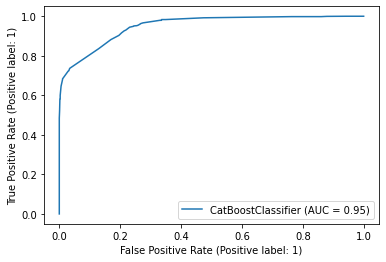

In [112]:
from catboost import CatBoostClassifier

model_catboss = CatBoostClassifier(learning_rate = 0.2, depth = 8, rsm = 1)

model_catboss.fit(X_train, Y_train)

#Prediction
cast_modelprediction=model_catboss.predict(X_test)

evaluate_model (model_catboss, X_test, y_test, cast_modelprediction)

# **Deep Learning**

# **ANN**

In [113]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [114]:
# Create a Sequential Neural Network model 
model = Sequential()
# Create an Input and a Hidden Layer
model.add(Dense(units=50,activation="relu",kernel_initializer="he_uniform"))
# Create an Output Layer
model.add(Dense(units=1,activation="sigmoid"))
# Now, my model is ready to compile
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [115]:
model.fit(X_train,y_train,batch_size=64,epochs=100)

ValueError: Data cardinality is ambiguous:
  x sizes: 10304
  y sizes: 9016
Make sure all arrays contain the same number of samples.

In [ ]:
model.summary()

In [ ]:
# Predict the X_test results
y_pred = model.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# **LSTM**

In [ ]:
# Import the necessary libraries for ANN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Dropout

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
regressor.summary()

In [ ]:
# Predict the X_test results
y_pred = regressor.predict(X_test)

In [ ]:
y_pred_label = []
for i in range(0, len(y_pred)):
  if y_pred[i] >= 0.5:
    y_pred_label.append(1)
  else:
    y_pred_label.append(0)

In [ ]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",metrics.accuracy_score(y_pred_label,y_test))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(y_pred_label,y_test))
# recall_score
print('3. recall_score: ', recall_score(y_pred_label,y_test))
# precision_score
print('4. precision_score: ', precision_score(y_pred_label,y_test))
# f1_score
print('5. f1_score: ', f1_score(y_pred_label,y_test))

# ***Kết thúc!***